In [ ]:
# Install required packages and poppler-utils
!apt-get update
!apt-get install -y poppler-utils
!pip install -q google-generativeai kdbai-client sentence-transformers pdf2image

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main

##### Connect to KDB.AI

In [ ]:
import os
import google.generativeai as genai
from getpass import getpass
import kdbai_client as kdbai

KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)

KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

GOOGLE_API_KEY = (
    os.environ["GOOGLE_API_KEY"]
    if "GOOGLE_API_KEY" in os.environ
    else getpass("Google API key: ")
)

# Create a KDB.AI session and database reference
session = kdbai.Session(endpoint=KDBAI_ENDPOINT, api_key=KDBAI_API_KEY)
db = session.database('default')
print("Connected to KDB.AI. Existing tables:", db.tables)

Connected to KDB.AI. Existing tables: [KDBAI table "eval_s", KDBAI table "eval_t", KDBAI table "eval_a", KDBAI table "gme_analysis", KDBAI table "gme_intraday", KDBAI table "gme_minute_analysis", KDBAI table "transcript_chunks", KDBAI table "market_data", KDBAI table "earthquake_tss", KDBAI table "documentation_chunks", KDBAI table "gme_data", KDBAI table "aapl_data", KDBAI table "cranfield_hybrid_search", KDBAI table "document_data", KDBAI table "documentss", KDBAI table "documentsss", KDBAI table "synthetic_data", KDBAI table "documentation2", KDBAI table "hotpotqa_corpus", KDBAI table "health_data", KDBAI table "documentation", KDBAI table "your_table_name", KDBAI table "random_embeddings", KDBAI table "paul_graham", KDBAI table "multi_modal_Voyage", KDBAI table "pdf_embeddings"]


##### Initialize Embedding Model

In [ ]:
# Define table schema and index for the vector store
VECTOR_DIM = 384  # dimension of embedding vectors (adjust if using a different model)

schema = [
    {"name": "id", "type": "str"},          # unique identifier for the chunk
    {"name": "text", "type": "str"},        # the text content of the chunk
    {"name": "vectors", "type": "float32s"} # embedding vector (array of float32)
]
index = [
    {
        "name": "flat_index",    # name of the vector index
        "type": "flat",          # flat index (brute-force)
        "column": "vectors",     # column on which to build the index
        "params": {"dims": VECTOR_DIM, "metric": "L2"}  # L2 = Euclidean distance&#8203;:contentReference[oaicite:13]{index=13}
    }
]

# Create the table (if it exists from a previous run, drop it first)
table_name = "pdf_embeddings"
try:
    db.table(table_name).drop()  # drop old table to start fresh
except kdbai.KDBAIException:
    pass

table = db.create_table(table_name, schema=schema, indexes=index)
print(f"Vector store table '{table_name}' created. Current tables: {db.tables}")

Vector store table 'pdf_embeddings' created. Current tables: [KDBAI table "eval_s", KDBAI table "eval_t", KDBAI table "eval_a", KDBAI table "gme_analysis", KDBAI table "gme_intraday", KDBAI table "gme_minute_analysis", KDBAI table "transcript_chunks", KDBAI table "market_data", KDBAI table "earthquake_tss", KDBAI table "documentation_chunks", KDBAI table "gme_data", KDBAI table "aapl_data", KDBAI table "cranfield_hybrid_search", KDBAI table "document_data", KDBAI table "documentss", KDBAI table "documentsss", KDBAI table "synthetic_data", KDBAI table "documentation2", KDBAI table "hotpotqa_corpus", KDBAI table "health_data", KDBAI table "documentation", KDBAI table "your_table_name", KDBAI table "random_embeddings", KDBAI table "paul_graham", KDBAI table "multi_modal_Voyage", KDBAI table "pdf_embeddings"]


### Data Preparation


##### Download Dataset
We'll use the Paul Graham Essay Dataset as our corpus.

In [ ]:
import os
import re
import base64
import requests
import textwrap
import pandas as pd
import numpy as np
from io import BytesIO
from IPython.display import display, Image
import concurrent.futures

# Import pdf2image to convert PDF pages to images
from pdf2image import convert_from_bytes

# Import the SentenceTransformer for later embedding steps
from sentence_transformers import SentenceTransformer

# Import Google Generative AI (Gemini Flash) client
import google.generativeai as genai

# Define a public PDF URL (using an arXiv paper as an example)
pdf_url = "https://arxiv.org/pdf/2404.08865"
print("Downloading PDF from:", pdf_url)
response = requests.get(pdf_url)
if response.status_code != 200:
    raise ValueError("Failed to download PDF.")
pdf_bytes = response.content

# Convert ALL pages of the PDF to images
pages = convert_from_bytes(pdf_bytes)
if not pages:
    raise ValueError("No pages were converted from the PDF.")
print(f"Converted {len(pages)} pages from the PDF to images.")

# Save each page image and also store its base64 representation for later display.
page_images_b64 = {}  # Mapping: page number -> base64 image data
for i, page in enumerate(pages, start=1):
    image_filename = f"page_{i}.png"
    page.save(image_filename)
    with open(image_filename, "rb") as img_file:
        image_data = img_file.read()
    image_b64 = base64.b64encode(image_data).decode("utf-8")
    page_images_b64[i] = image_b64
print("Saved and encoded all page images.")

Converted 17 pages from the PDF to images.
Saved and encoded all page images.


In [ ]:
!pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00


Gemini model loaded: genai.GenerativeModel(
    model_name='models/gemini-2.0-flash',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)
Downloaded PDF successfully.


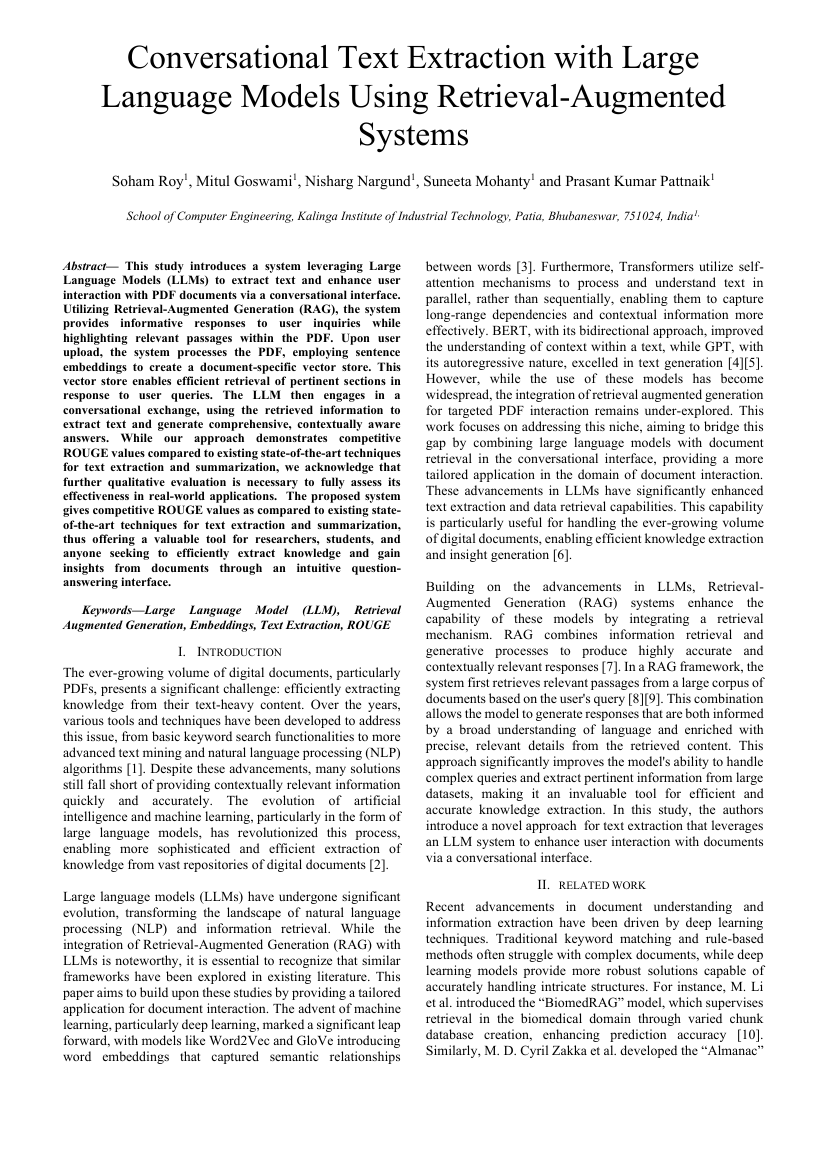

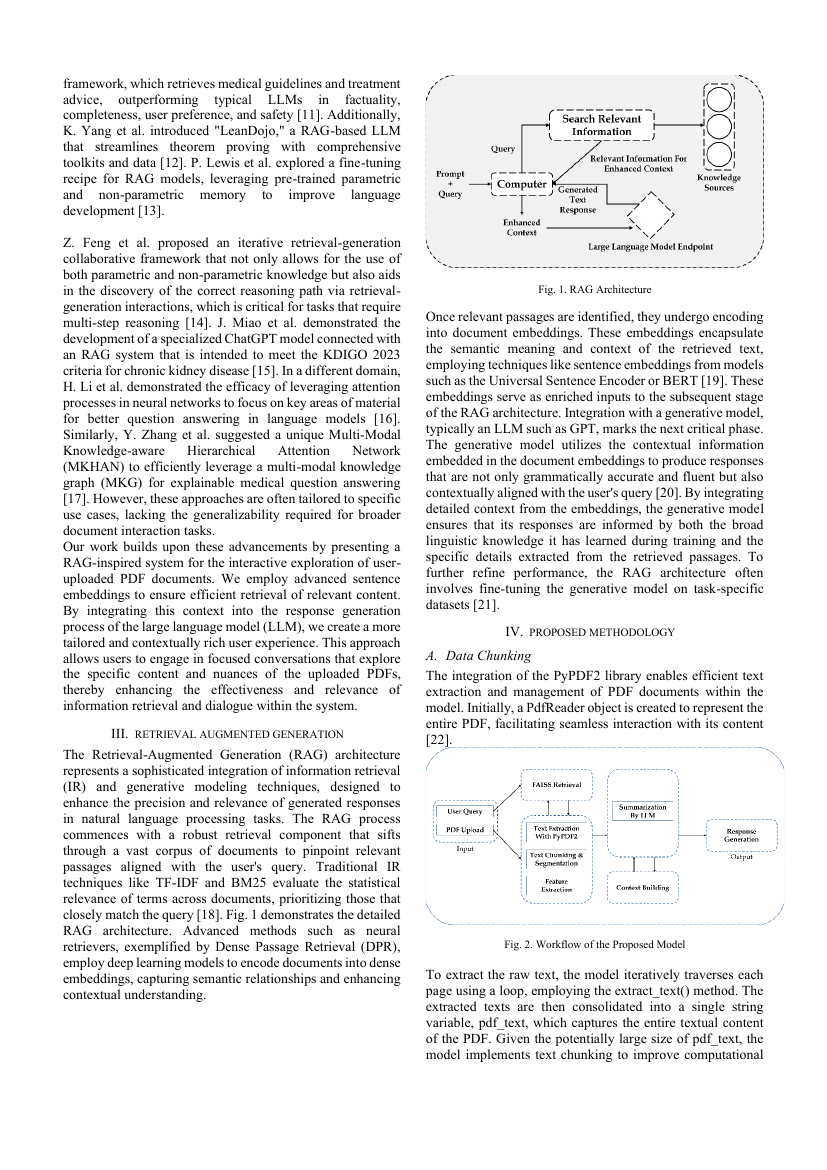

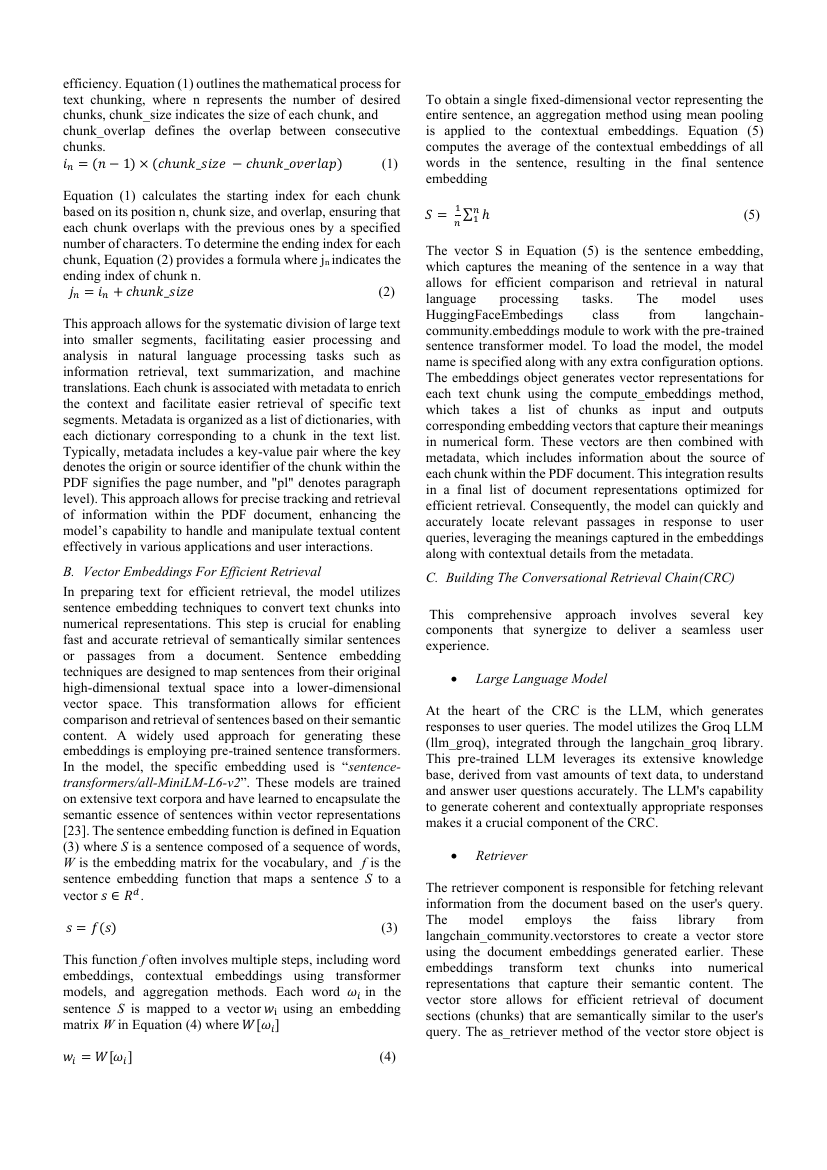

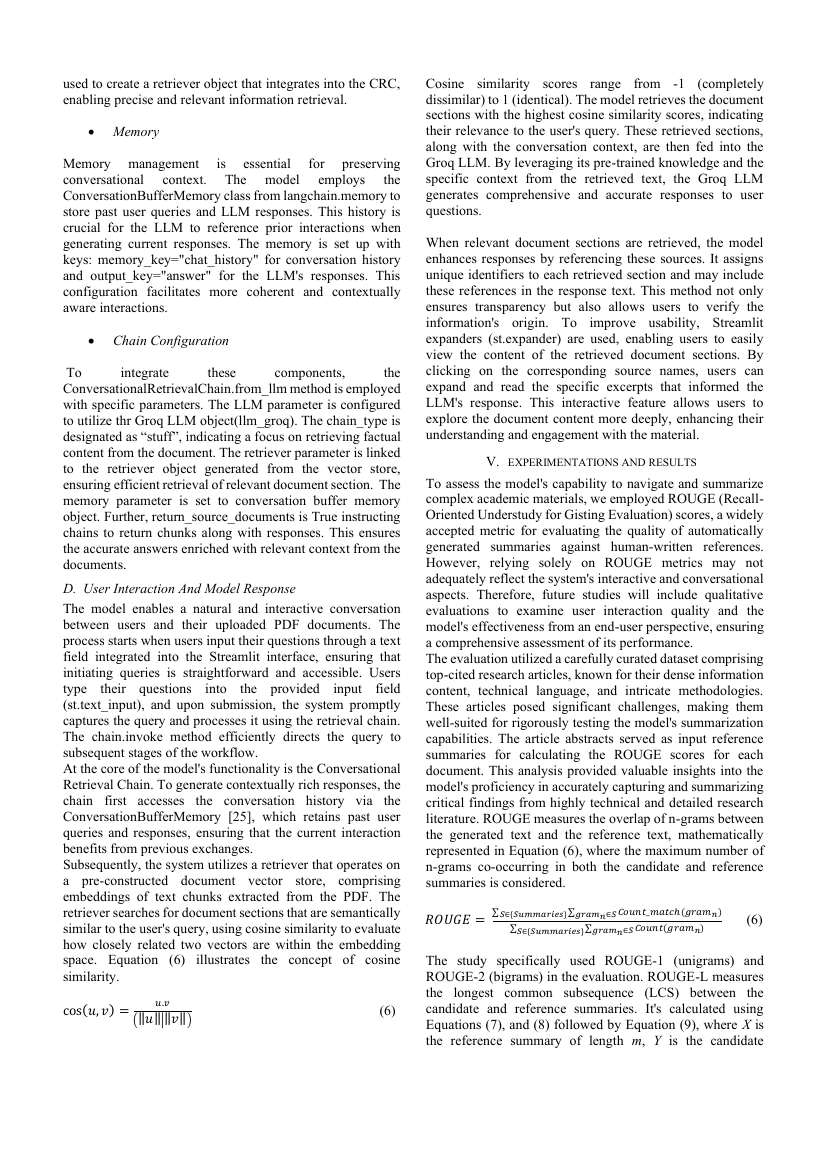

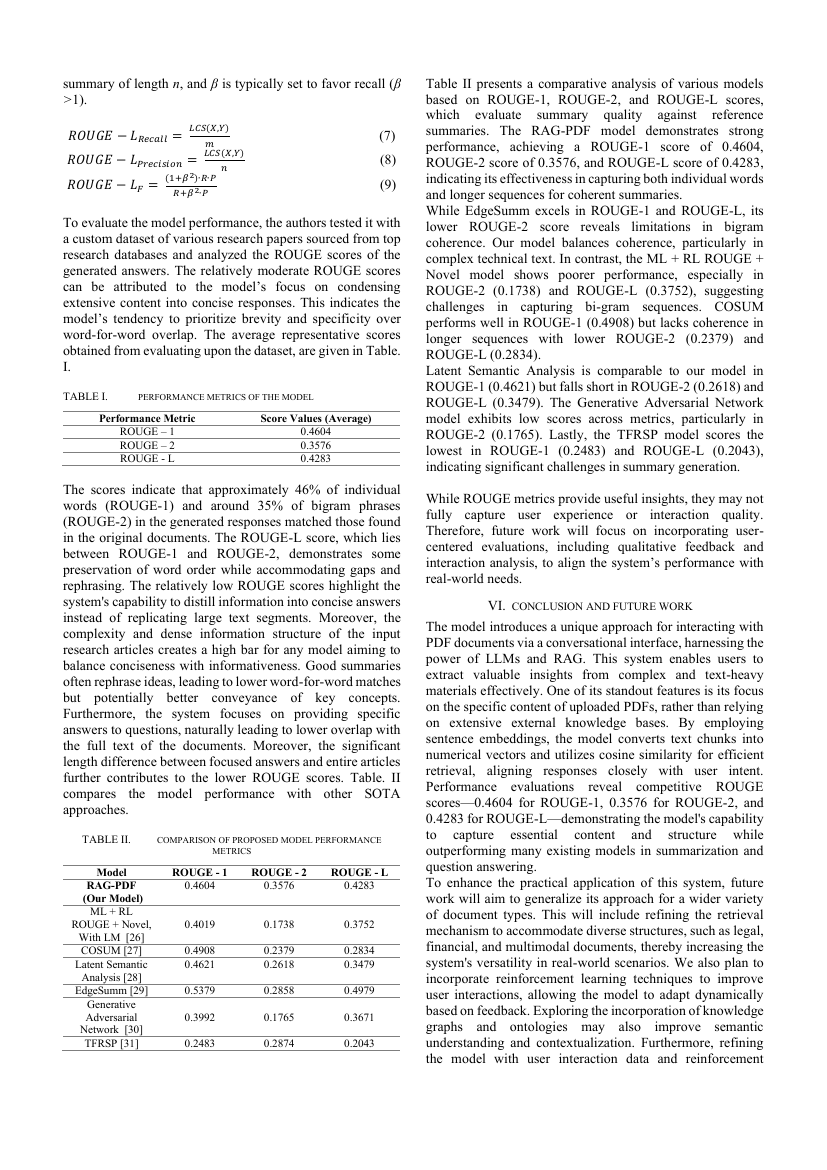

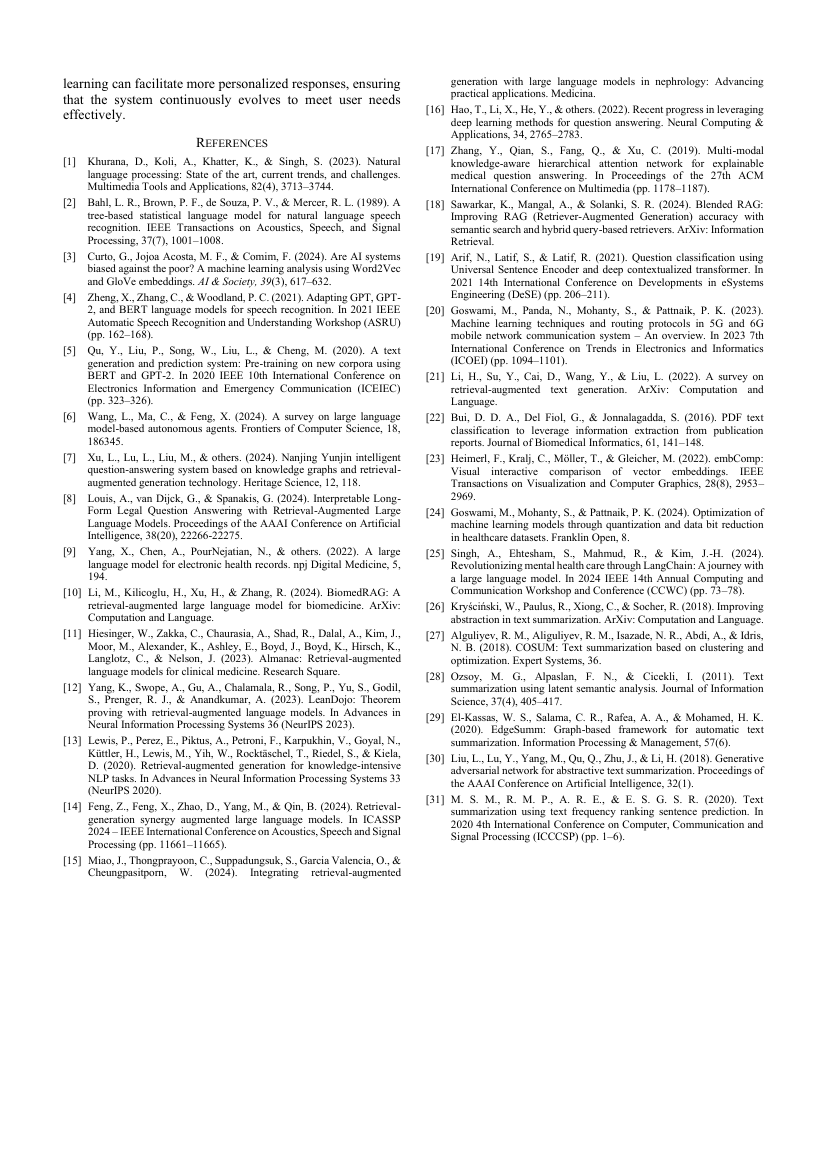

Converted 6 pages from the PDF at dpi=100.
Processing page 1 asynchronously...
Processing page 2 asynchronously...
Processing page 3 asynchronously...
Processing page 4 asynchronously...
Processing page 5 asynchronously...
Processing page 6 asynchronously...
Page 1: Extracted 4 chunks.
Page 2: Extracted 7 chunks.
Page 3: Extracted 4 chunks.
Page 4: Extracted 6 chunks.
Page 5: Extracted 6 chunks.
Page 6: Extracted 5 chunks.

Total extracted chunks from the first 6 pages: 32
Page: 1 - ID: page_1_chunk_0 - snippet: 'Conversational Text Extraction with Large\nLanguage Models Using Retrieval-Augmented\nSystems\n\nSoham R'
Page: 1 - ID: page_1_chunk_1 - snippet: 'I. INTRODUCTION\n\nThe ever-growing volume of digital documents, particularly PDFs, presents a signifi'
Page: 1 - ID: page_1_chunk_2 - snippet: 'Furthermore, Transformers utilize self-attention mechanisms to process and understand text in parall'
Page: 1 - ID: page_1_chunk_3 - snippet: 'II. RELATED WORK\n\nRecent advancements in doc

In [ ]:
import asyncio
import aiohttp
import base64
import re
import io
import os

from pdf2image import convert_from_bytes  # pip install pdf2image
from PIL import Image  # pip install pillow
import google.generativeai as genai
import nest_asyncio
nest_asyncio.apply()

# Configure your API key (ensure GOOGLE_API_KEY is set in your environment)
genai.configure(api_key=GOOGLE_API_KEY)

# We'll load the Gemini 2.0 Flash Lite model
model = genai.GenerativeModel(model_name="gemini-2.0-flash")
print("Gemini model loaded:", model)

# URL for the PDF
pdf_url = "https://arxiv.org/pdf/2501.09801"

async def download_pdf(url: str) -> bytes:
    """Asynchronously download a PDF from a URL and return its bytes."""
    print("Downloading PDF from:", url)
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as resp:
            if resp.status != 200:
                raise ValueError(f"Failed to download PDF. HTTP status: {resp.status}")
            return await resp.read()

async def process_page_async(page_num: int, image: Image.Image, prompt: str) -> list:
    """
    Process one page: convert the image to a base64 string, call Gemini for OCR
    and chunking, and return a list of chunk dictionaries.
    """
    print(f"Processing page {page_num} asynchronously...")
    # Convert the page image to an in-memory PNG and Base64-encode
    buffer = io.BytesIO()
    image.save(buffer, format="PNG")
    image_b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    payload = [
        {"inline_data": {"data": image_b64, "mime_type": "image/png"}},
        {"text": prompt}
    ]

    # Because the library function is synchronous, we run it in a ThreadPoolExecutor:
    loop = asyncio.get_running_loop()
    try:
        def _sync_generate_content():
            return model.generate_content(
                payload,
                request_options={"timeout": 1000}
            )

        resp = await loop.run_in_executor(None, _sync_generate_content)
        text_out = resp.text
    except Exception as e:
        print(f"Error processing page {page_num}: {e}")
        return []

    # Extract <chunk> sections from the returned text.
    chunks = re.findall(r"<chunk>(.*?)</chunk>", text_out, re.DOTALL)
    if not chunks:
        # Fallback: split on double newlines.
        chunks = [c.strip() for c in text_out.split("\n\n") if c.strip()]

    print(f"Page {page_num}: Extracted {len(chunks)} chunks.")
    results = []
    for idx, chunk_txt in enumerate(chunks):
        results.append({
            "id": f"page_{page_num}_chunk_{idx}",
            "chunk_text": chunk_txt.strip(),
            "page": page_num
        })
    return results

all_chunks = []

async def main():
    # ------------------------------
    # 1. Download & Convert the PDF
    # ------------------------------
    pdf_bytes = await download_pdf(pdf_url)
    print("Downloaded PDF successfully.")

    # Convert all pages to images at a lower DPI to reduce file size
    pages = convert_from_bytes(pdf_bytes, dpi=100)
    # display pages
    for page in pages:
        display(page)
    print(f"Converted {len(pages)} pages from the PDF at dpi=100.")

    # ------------------------------
    # 2. Process the Pages in Parallel
    # ------------------------------
    CHUNKING_PROMPT = (
        "OCR the following page into Markdown. Tables should be formatted as HTML.\n"
        "Do not surround your output with triple backticks.\n\n"
        "Chunk the document into sections of roughly 250 - 1000 words. Our goal is\n"
        "to identify parts of the page with the same semantic theme. These chunks will\n"
        "be embedded and used in a RAG pipeline.\n\n"
        "Surround the chunks with <chunk> and </chunk> html tags."
        "Make sure to break up chunks much how a human would, and also to include all the data in the document."
    )

    num_pages_to_process = len(pages)

    # Create tasks for processing pages concurrently
    tasks = [
        asyncio.create_task(process_page_async(i, pages[i - 1], CHUNKING_PROMPT))
        for i in range(1, num_pages_to_process + 1)
    ]

    # Wait for tasks to finish
    results = await asyncio.gather(*tasks, return_exceptions=True)

    # Combine everything
    for res in results:
        if isinstance(res, Exception):
            print("Error during processing:", res)
        else:
            all_chunks.extend(res)

    print(f"\nTotal extracted chunks from the first {num_pages_to_process} pages: {len(all_chunks)}")
    for c in all_chunks:
        snippet = c['chunk_text'][:100]
        print(f"Page: {c['page']} - ID: {c['id']} - snippet: {snippet!r}")

# Only run if invoked directly
if __name__ == "__main__":
    asyncio.run(main())


### Create a KDB.AI session and table

In [ ]:
# Load the embedding model (e.g., all-MiniLM-L6-v2 produces 384-dim embeddings)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Get the list of chunk texts
chunk_texts = [entry["chunk_text"] for entry in all_chunks]
print(chunk_texts)

# Compute embeddings for all chunks
chunk_embeddings = embedding_model.encode(chunk_texts)
chunk_embeddings = np.array(chunk_embeddings, dtype=np.float32)
print("Computed embeddings for all chunks. Shape:", chunk_embeddings.shape)

# Prepare a list for DataFrame insertion, including the page number.
data_list = []
for idx, entry in enumerate(all_chunks):
    data_list.append({
        "id": entry["id"],
        "chunk_text": entry["chunk_text"],
        "page": entry["page"],
        "vectors": chunk_embeddings[idx].tolist()
    })

data_df = pd.DataFrame(data_list)
print("Sample DataFrame:")
display(data_df.head())

# Define the KDB.AI table schema with an extra column for page number.
VECTOR_DIM = 384
schema = [
    {"name": "id", "type": "str"},
    {"name": "chunk_text", "type": "str"},
    {"name": "page", "type": "int32"},
    {"name": "vectors", "type": "float32s"}
]
indexes = [{
    "name": "flat_index",
    "type": "flat",
    "column": "vectors",
    "params": {"dims": VECTOR_DIM, "metric": "L2"}
}]

table_name = "pdf_chunks"
try:
    db.table(table_name).drop()
except kdbai.KDBAIException:
    pass

table = db.create_table(table_name, schema=schema, indexes=indexes)
print(f"Created table '{table_name}' in KDB.AI.")

# Insert the data into KDB.AI
table.insert(data_df)
print(f"Inserted {len(data_df)} chunks into table '{table_name}'.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

['Conversational Text Extraction with Large\nLanguage Models Using Retrieval-Augmented\nSystems\n\nSoham Roy¹, Mitul Goswami¹, Nisharg Nargund¹, Suneeta Mohanty¹ and Prasant Kumar Pattnaik¹\n\nSchool of Computer Engineering, Kalinga Institute of Industrial Technology, Patia, Bhubaneswar, 751024, India¹\n\n**Abstract** This study introduces a system leveraging Large Language Models (LLMs) to extract text and enhance user interaction with PDF documents via a conversational interface. Utilizing Retrieval-Augmented Generation (RAG), the system provides informative responses to user inquiries while highlighting relevant passages within the PDF. Upon user upload, the system processes the PDF, employing sentence embeddings to create a document-specific vector store. This vector store enables efficient retrieval of pertinent sections in response to user queries. The LLM then engages in a conversational exchange, using the retrieved information to extract text and generate comprehensive, contex

id                                         chunk_text  page  \
0  page_1_chunk_0  Conversational Text Extraction with Large\nLan...     1   
1  page_1_chunk_1  I. INTRODUCTION\n\nThe ever-growing volume of ...     1   
2  page_1_chunk_2  Furthermore, Transformers utilize self-attenti...     1   
3  page_1_chunk_3  II. RELATED WORK\n\nRecent advancements in doc...     1   
4  page_2_chunk_0  framework, which retrieves medical guidelines ...     2   

                                             vectors  
0  [-0.09518160670995712, -0.007127390243113041, ...  
1  [-0.09608577936887741, -0.02303382381796837, 0...  
2  [-0.14992767572402954, -0.021675704047083855, ...  
3  [-0.12416603416204453, 0.04156530275940895, 0....  
4  [-0.02884676866233349, -0.01312265545129776, 0...

Created table 'pdf_chunks' in KDB.AI.
Inserted 32 chunks into table 'pdf_chunks'.


In [ ]:
# create a df from chunks and print full text
table.query()

id                                         chunk_text  page  \
0   page_1_chunk_0  Conversational Text Extraction with Large\nLan...     1   
1   page_1_chunk_1  I. INTRODUCTION\n\nThe ever-growing volume of ...     1   
2   page_1_chunk_2  Furthermore, Transformers utilize self-attenti...     1   
3   page_1_chunk_3  II. RELATED WORK\n\nRecent advancements in doc...     1   
4   page_2_chunk_0  framework, which retrieves medical guidelines ...     2   
5   page_2_chunk_1  Z. Feng et al. proposed an iterative retrieval...     2   
6   page_2_chunk_2  Our work builds upon these advancements by pre...     2   
7   page_2_chunk_3  III. RETRIEVAL AUGMENTED GENERATION\nThe Retri...     2   
8   page_2_chunk_4  Once relevant passages are identified, they un...     2   
9   page_2_chunk_5  IV. PROPOSED METHODOLOGY\nA. Data Chunking\nTh...     2   
10  page_2_chunk_6  To extract the raw text, the model iteratively...     2   
11  page_3_chunk_0  efficiency. Equation (1) outlines the mathemat...     3   
12  page_3_chunk_1  B. Vector Embeddings For Efficient Retrieval\n...     3   
13  page_3_chunk_2  To obtain a single fixed-dimensional vector re...     3   
14  page_3_chunk_3  C. Building The Conversational Retrieval Chain...     3   
15  page_4_chunk_0  ```html\n<p>used to create a retriever object ...     4   
16  page_4_chunk_1  D. User Interaction And Model Response\nThe mo...     4   
17  page_4_chunk_2  Subsequently, the system utilizes a retriever ...     4   
18  page_4_chunk_3  When relevant document sections are retrieved,...     4   
19  page_4_chunk_4  V. EXPERIMENTATIONS AND RESULTS\nTo assess the...     4   
20  page_4_chunk_5  ROUGE = Ese(Summaries) Egramnes Count_match(gr...     4   
21  page_5_chunk_0  summary of length n, and ẞ is typically set to...     5   
22  page_5_chunk_1  The scores indicate that approximately 46% of ...     5   
23  page_5_chunk_2  TABLE II. COMPARISON OF PROPOSED MODEL PERFORM...     5   
24  page_5_chunk_3  Table II presents a comparative analysis of va...     5   
25  page_5_chunk_4  While ROUGE metrics provide useful insights, t...     5   
26  page_5_chunk_5  Performance evaluations reveal competitive ROU...     5   
27  page_6_chunk_0  learning can facilitate more personalized resp...     6   
28  page_6_chunk_1  [6] Wang, L., Ma, C., & Feng, X. (2024). A sur...     6   
29  page_6_chunk_2  [12] Yang, K., Swope, A., Gu, A., Chalamala, R...     6   
30  page_6_chunk_3  [16] Hao, T., Li, X., He, Y., & others. (2022)...     6   
31  page_6_chunk_4  [22] Bui, D. D. A., Del Fiol, G., & Jonnalagad...     6   

                                              vectors  
0   [-0.09518161, -0.0071273902, -0.028903328, 0.0...  
1   [-0.09608578, -0.023033824, 0.015351164, 0.065...  
2   [-0.14992768, -0.021675704, 0.013172909, 0.050...  
3   [-0.124166034, 0.041565303, 0.00029655598, -0....  
4   [-0.028846769, -0.013122655, 0.01729479, -0.01...  
5   [-0.051342502, -0.038146, 0.012712781, 0.03911...  
6   [-0.016111026, -0.035711214, -0.02389946, 0.06...  
7   [-0.0561986, -0.0421292, 0.030780872, 0.055045...  
8   [-0.039012328, -9.99076e-05, 0.049268376, 0.04...  
9   [-0.033753134, 0.00179662, -0.06255387, -0.009...  
10  [-0.058911584, 0.025358379, -0.066329665, 0.00...  
11  [-0.06188826, 0.09051599, -0.018571269, 0.0129...  
12  [-0.019978149, -0.017667342, 0.026427696, 0.04...  
13  [-0.052362163, -0.003892005, 0.0058683963, 0.0...  
14  [-0.072744794, -0.037322093, -0.0074591585, 0....  
15  [-0.03319686, -0.016317042, -0.041445844, 0.02...  
16  [-0.05888301, -0.02024492, -0.0044803093, 0.01...  
17  [-0.04608789, -0.018138481, -0.08267272, 0.017...  
18  [-0.06691187, -0.009745397, -0.039891396, 0.08...  
19  [-0.03657636, -0.019403487, -0.019823797, 0.05...  
20  [-0.022553822, -0.07220581, -0.025486266, -0.0...  
21  [0.0076882034, -0.102766916, -0.061579864, 0.0...  
22  [-0.00829355, -0.007759821, -0.022499507, 0.03...  
23  [0.06610424, -0.08141829, -0.09948838, 0.00883...  
24  [0.0

In [ ]:
# Example user query
user_query = "How does retrieval-augmented generation help large language models handle complex queries effectively?"

# Embed the user query
query_embedding = embedding_model.encode(user_query)
query_embedding = np.array(query_embedding, dtype=np.float32)

# Perform similarity search in KDB.AI for the top 2 matching chunks
results = table.search(vectors={"flat_index": [query_embedding]}, n=2)

chunks = ([t.strip() for t in results[0]['chunk_text']])

# pretty print chunks
for chunk in chunks:
    print(textwrap.fill(chunk, width=80))

# Combine retrieved chunks as context
retrieved_context = "\n\n".join(results[0]["chunk_text"].tolist())
final_prompt = f"""Use the following context to answer the question.

Context:
{retrieved_context}

Question: {user_query}
Answer:"""

# Generate final answer using Gemini Flash 2.0
final_response = model.generate_content(final_prompt)
print("\nFinal Answer from Gemini:")
print(textwrap.fill(final_response.text, width=80))


[12] Yang, K., Swope, A., Gu, A., Chalamala, R., Song, P., Yu, S., Godil, S.,
Prenger, R. J., & Anandkumar, A. (2023). LeanDojo: Theorem proving with
retrieval-augmented language models. In Advances in Neural Information
Processing Systems 36 (NeurIPS 2023). [13] Lewis, P., Perez, E., Piktus, A.,
Petroni, F., Karpukhin, V., Goyal, N., Küttler, H., Lewis, M., Yih, W.,
Rocktäschel, T., Riedel, S., & Kiela, D. (2020). Retrieval-augmented generation
for knowledge-intensive NLP tasks. In Advances in Neural Information Processing
Systems 33 (NeurIPS 2020). [14] Feng, Z., Feng, X., Zhao, D., Yang, M., & Qin,
B. (2024). Retrieval- generation synergy augmented large language models. In
ICASSP 2024-IEEE International Conference on Acoustics, Speech and Signal
Processing (pp. 11661-11665). [15] Miao, J., Thongprayoon, C., Suppadungsuk, S.,
Garcia Valencia, O., & Cheungpasitporn, W. (2024). Integrating retrieval-
augmented generation with large language models in nephrology: Advancing
practical ap

In [ ]:
table.drop()
print(f"Dropped table '{table_name}'.")

Dropped table 'pdf_chunks'.
